In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, date

# Load data

Use 1 month of data from the Hainich site and using a subset of variables

Note for simplicity gap filled values are not excluded

In [3]:
hai_path = Path("FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv")
hai_raw = pd.read_csv("../MeteoECGapFilling/data" / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1])

In [4]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    "PA_F": "PA"
}

hai = (hai_raw[
           hai_raw.TIMESTAMP_START.between(
               datetime(2000, 1, 1),
               datetime(2000, 1, 31)
           )]
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])

In [5]:
hai

,TA,SW_IN,LW_IN,VPD,PA,PA
TIMESTAMP_END,,,,,,
2000-01-01 00:30:00,-0.60,0.00,302.475,0.222,96.63,96.63
2000-01-01 01:00:00,-0.65,0.00,302.475,0.122,96.58,96.58
2000-01-01 01:30:00,-0.58,0.00,301.677,0.090,96.56,96.56
2000-01-01 02:00:00,-0.51,0.00,301.677,0.110,96.56,96.56
2000-01-01 02:30:00,-0.49,0.00,301.677,0.102,96.57,96.57
...,...,...,...,...,...,...
2000-01-30 22:30:00,6.87,0.19,346.510,0.189,95.50,95.50
2000-01-30 23:00:00,7.45,0.06,346.510,0.620,95.47,95.47
2000-01-30 23:30:00,7.66,0.00,346.510,0.842,95.45,95.45


# Gaussian Process

In [6]:
import torch
import gpytorch
from matplotlib import pyplot as plt

## Functions

In [7]:
# add a column "time" which is going to be the x variable, while TA is the y
train_x = torch.linspace(0, 1, len(hai)).cuda()
train_y = torch.tensor(hai.TA, dtype=torch.float).cuda()
#train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.04))

In [8]:
def train(model, likelihood, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

@torch.no_grad()
def plot_prediction(pred_dist, test_x = torch.linspace(0, 1, 51)):
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    # Get upper and lower confidence bounds
    lower, upper = pred_dist.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), pred_dist.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([11, -11]) #TODO hardcoded
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1,  loss.item(),
        self.covar_module.base_kernel.lengthscale.item(),
        self.likelihood.noise.item()
    ))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()


In [10]:
test_x = torch.linspace(0, 1, len(hai) * 2).cuda()

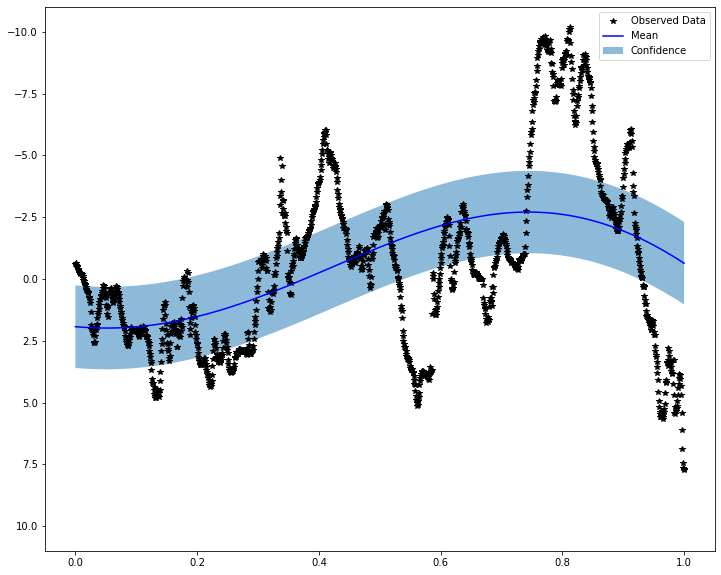

In [11]:
pred = predict(model, likelihood, test_x)
plot_prediction(pred, test_x)

In [12]:
train(model, likelihood)

Iter 1 - Loss: 8.033   lengthscale: 0.644   noise: 0.744
Iter 2 - Loss: 7.470   lengthscale: 0.598   noise: 0.798
Iter 3 - Loss: 6.960   lengthscale: 0.555   noise: 0.853
Iter 4 - Loss: 6.511   lengthscale: 0.514   noise: 0.911
Iter 5 - Loss: 6.115   lengthscale: 0.476   noise: 0.969
Iter 6 - Loss: 5.752   lengthscale: 0.440   noise: 1.029
Iter 7 - Loss: 5.416   lengthscale: 0.406   noise: 1.090
Iter 8 - Loss: 5.088   lengthscale: 0.374   noise: 1.151
Iter 9 - Loss: 4.749   lengthscale: 0.344   noise: 1.212
Iter 10 - Loss: 4.374   lengthscale: 0.315   noise: 1.272
Iter 11 - Loss: 3.961   lengthscale: 0.289   noise: 1.331
Iter 12 - Loss: 3.527   lengthscale: 0.264   noise: 1.388
Iter 13 - Loss: 3.112   lengthscale: 0.241   noise: 1.442
Iter 14 - Loss: 2.764   lengthscale: 0.219   noise: 1.493
Iter 15 - Loss: 2.500   lengthscale: 0.200   noise: 1.541
Iter 16 - Loss: 2.325   lengthscale: 0.182   noise: 1.586
Iter 17 - Loss: 2.209   lengthscale: 0.167   noise: 1.628
Iter 18 - Loss: 2.144  

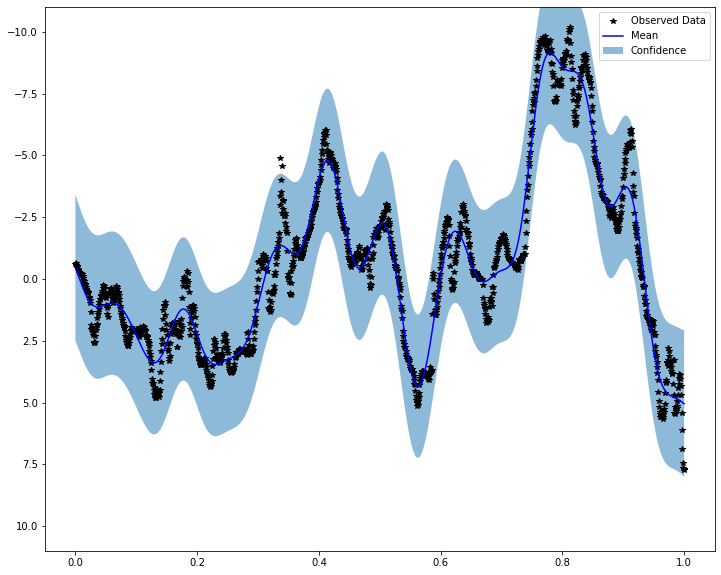

In [13]:
pred = predict(model, likelihood, test_x)
plot_prediction(pred, test_x)

# Gaussian Processess Neural Netwrok Feature Extractor

in this case the dimension reduction is done in the x variables, while for factor analysis is done on the y variable, which makes everything a bit harder 🤓

 so what we need to do?
take inspiration from https://docs.gpytorch.ai/en/stable/examples/045_GPLVM/Gaussian_Process_Latent_Variable_Models_with_Stochastic_Variational_Inference.html
 or better from https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html

In [14]:
# We will use the simplest form of GP model, exact inference
class GPNNfeature(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_dim_latent = 1):
        super(self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        n_dim_input = train_x.shape[-1]
        self.dim_reduce = torch.nn.Linear(n_dim_input, n_dim_latent)

    def forward(self, x):
        z = self.dim_reduce(x)
        mean_z = self.mean_module(z)
        covar_z = self.covar_module(z)
        return gpytorch.distributions.MultivariateNormal(mean_z, covar_z)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1,  loss.item(),
        self.covar_module.base_kernel.lengthscale.item(),
        self.likelihood.noise.item()
    ))

In [15]:
all_y = hai.TA.to_numpy()[None, :]
all_y

array([[-0.6 , -0.65, -0.58, ...,  7.66,  7.69,  7.75]])

In [16]:
all_x = hai.drop("TA", axis = 1).to_numpy().T
all_x

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.02475e+02, 3.02475e+02, 3.01677e+02, ..., 3.46510e+02,
        3.46510e+02, 3.46510e+02],
       [2.22000e-01, 1.22000e-01, 9.00000e-02, ..., 8.42000e-01,
        8.86000e-01, 1.07900e+00],
       [9.66300e+01, 9.65800e+01, 9.65600e+01, ..., 9.54500e+01,
        9.54500e+01, 9.54400e+01],
       [9.66300e+01, 9.65800e+01, 9.65600e+01, ..., 9.54500e+01,
        9.54500e+01, 9.54400e+01]])

# Gaussian Process factor Analysis

In [17]:
from plotnine import ggplot, geom_point, aes

In [18]:
hai["time"] = np.arange(0, len(hai))

In [19]:
hai["TA"]

TIMESTAMP_END
2000-01-01 00:30:00   -0.60
2000-01-01 01:00:00   -0.65
2000-01-01 01:30:00   -0.58
2000-01-01 02:00:00   -0.51
2000-01-01 02:30:00   -0.49
                       ... 
2000-01-30 22:30:00    6.87
2000-01-30 23:00:00    7.45
2000-01-30 23:30:00    7.66
2000-01-31 00:00:00    7.69
2000-01-31 00:30:00    7.75
Name: TA, Length: 1441, dtype: float64

to make it easier to visualize use ony the first 200 points

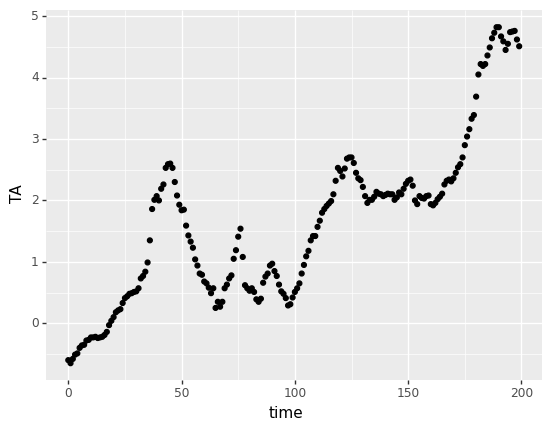

<ggplot: (8780457112940)>

In [20]:
(ggplot(hai[:200], aes('time', 'TA')) +
 geom_point()
 )

In [21]:
def normalize(x, axis=0):
    return (x - x.mean(axis=axis))/ x.std(axis=axis)

In [22]:
Y = hai[:200].drop("time", axis=1).to_numpy()
Y = normalize(Y)
Y

array([[-1.68358578, -0.44069223, -0.20302478, -0.22417922,  0.06317512,
         0.06317512],
       [-1.72115156, -0.44069223, -0.20302478, -0.54683209, -0.05513035,
        -0.05513035],
       [-1.66855946, -0.44069223, -0.24088634, -0.65008101, -0.10245254,
        -0.10245254],
       ...,
       [ 2.34346635, -0.44069223,  1.11249835,  2.07633577, -1.75872913,
        -1.75872913],
       [ 2.23828216, -0.44069223,  1.11249835,  2.80875779, -1.64042366,
        -1.64042366],
       [ 2.15563743, -0.44069223,  1.11249835,  4.33813241, -1.56944038,
        -1.56944038]])

In [23]:
X = hai[:200].time.to_numpy()
X = normalize(X)
X

array([-1.7234121 , -1.70609137, -1.68877065, -1.67144992, -1.6541292 ,
       -1.63680847, -1.61948775, -1.60216702, -1.5848463 , -1.56752558,
       -1.55020485, -1.53288413, -1.5155634 , -1.49824268, -1.48092195,
       -1.46360123, -1.4462805 , -1.42895978, -1.41163905, -1.39431833,
       -1.3769976 , -1.35967688, -1.34235616, -1.32503543, -1.30771471,
       -1.29039398, -1.27307326, -1.25575253, -1.23843181, -1.22111108,
       -1.20379036, -1.18646963, -1.16914891, -1.15182818, -1.13450746,
       -1.11718674, -1.09986601, -1.08254529, -1.06522456, -1.04790384,
       -1.03058311, -1.01326239, -0.99594166, -0.97862094, -0.96130021,
       -0.94397949, -0.92665877, -0.90933804, -0.89201732, -0.87469659,
       -0.85737587, -0.84005514, -0.82273442, -0.80541369, -0.78809297,
       -0.77077224, -0.75345152, -0.73613079, -0.71881007, -0.70148935,
       -0.68416862, -0.6668479 , -0.64952717, -0.63220645, -0.61488572,
       -0.597565  , -0.58024427, -0.56292355, -0.54560282, -0.52

In [24]:
# transfor only now to tensors because numpy has better pretty print
Y = torch.tensor(Y)
X = torch.tensor(X)

## Fixed Factor Analysis

In [25]:
latent_dim = 1
U, S, V = torch.pca_lowrank(Y, q = 1)
Z = torch.matmul(Y, V[:,:1]).squeeze()

In [26]:
Z.shape

torch.Size([200])

In [27]:
Z.numpy()

array([ 0.72553716,  0.66161967,  0.62567971,  0.59692214,  0.61942459,
        0.66366075,  0.65324523,  0.62674002,  0.47584143,  0.46584386,
        0.45453214,  0.4371283 ,  0.44505484,  0.41590302,  0.19070221,
        0.14679316,  0.17061752,  0.18266499,  0.25281052,  0.29359543,
        0.23326253,  0.21868474,  0.32152484,  0.1101031 ,  0.01230077,
       -0.04237754, -0.15957756, -0.27823066, -0.28011865, -0.27474083,
       -0.33244679, -0.38359606, -0.5791909 , -0.55335797, -0.49986684,
       -0.46856533, -0.47207687, -0.51890357, -0.57057016, -0.49148431,
       -0.39796835, -0.36415955, -0.35318031, -0.43557626,  0.30554296,
        0.3261758 ,  0.44127287,  0.56307997,  0.75823663,  0.8315025 ,
        1.3199692 ,  1.34970843,  1.49837154,  1.66042892,  1.72089945,
        1.75403571,  2.03499758,  2.06193257,  2.14477808,  2.17156694,
        2.28318834,  2.30377091,  2.55394501,  2.65132443,  2.66025409,
        2.94989161,  3.13258577,  3.23403473,  3.57270863,  3.59

In [28]:
def train(model, likelihood, train_x, train_y, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

@torch.no_grad()
def plot_prediction(pred_dist, train_x, train_y, test_x = torch.linspace(0, 1, 51)):
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    # Get upper and lower confidence bounds
    lower, upper = pred_dist.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), pred_dist.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [29]:
lh_sFA = gpytorch.likelihoods.GaussianLikelihood()
model_sFA = ExactGPModel(X, Z, lh_sFA)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352630480/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)


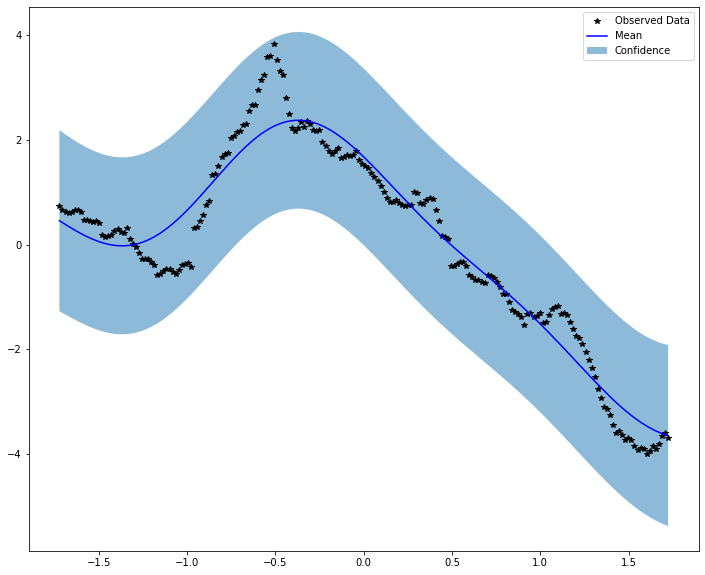

In [30]:
pred = predict(model_sFA, lh_sFA, X)
plot_prediction(pred, X, Z, X)

In [31]:
train(model_sFA, lh_sFA, train_x = X, train_y=Z)

Iter 1 - Loss: 1.039   lengthscale: 0.644   noise: 0.644
Iter 2 - Loss: 0.989   lengthscale: 0.598   noise: 0.598
Iter 3 - Loss: 0.940   lengthscale: 0.555   noise: 0.554
Iter 4 - Loss: 0.893   lengthscale: 0.514   noise: 0.513
Iter 5 - Loss: 0.846   lengthscale: 0.476   noise: 0.474
Iter 6 - Loss: 0.796   lengthscale: 0.440   noise: 0.437
Iter 7 - Loss: 0.743   lengthscale: 0.406   noise: 0.402
Iter 8 - Loss: 0.692   lengthscale: 0.374   noise: 0.369
Iter 9 - Loss: 0.645   lengthscale: 0.346   noise: 0.339
Iter 10 - Loss: 0.603   lengthscale: 0.322   noise: 0.310
Iter 11 - Loss: 0.563   lengthscale: 0.301   noise: 0.284
Iter 12 - Loss: 0.527   lengthscale: 0.284   noise: 0.259
Iter 13 - Loss: 0.491   lengthscale: 0.271   noise: 0.237
Iter 14 - Loss: 0.456   lengthscale: 0.260   noise: 0.216
Iter 15 - Loss: 0.421   lengthscale: 0.252   noise: 0.196
Iter 16 - Loss: 0.386   lengthscale: 0.246   noise: 0.179
Iter 17 - Loss: 0.350   lengthscale: 0.240   noise: 0.162
Iter 18 - Loss: 0.314  

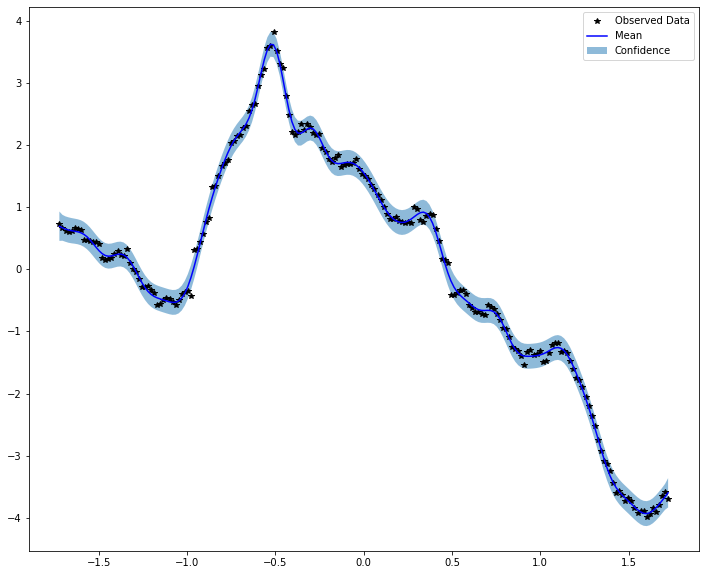

In [32]:
pred = predict(model_sFA, lh_sFA, X)
plot_prediction(pred, X, Z, X)

## Training factor analysis attempt 1

In [33]:
# We will use the simplest form of GP model, exact inference
class GPFA(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        with torch.no_grad():
            transform = self._init_pca(train_y)
            train_targets = torch.matmul(train_y, transform)
        super(GPFA, self).__init__(train_x, train_targets, likelihood)

        self.train_y = train_y # This is the original data, which is going to be retransformed at every iteration

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transform = torch.nn.Parameter(transform)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def update_training_data(self):
        targets = torch.matmul(self.train_y, self.transform)
        self.set_train_data(targets=targets)

    def __call__(self, *args, **kwargs):
        self.update_training_data()
        return super().__call__(*args, **kwargs)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f transform: %.3f' % (
            i + 1,  loss.item(),
            self.covar_module.base_kernel.lengthscale.item(),
            self.likelihood.noise.item(),
            self.transform[0].item()
        ))

    @property
    @torch.no_grad()
    def latent(self):
        return torch.matmul(self.train_y, self.transform)

    def _init_pca(self, train_y):
        U, S, V = torch.pca_lowrank(train_y, q = 1)
        return V[:,:1].squeeze()

# need to seed for reproducible PCA in pytorch, see https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html
torch.manual_seed(100)
# initialize likelihood and model
lh_FA = gpytorch.likelihoods.GaussianLikelihood()
m_FA = GPFA(X, Y, lh_FA)

In [34]:
m_FA.eval()
pred_dist = m_FA(X)

In [35]:
pred_dist

MultivariateNormal(loc: torch.Size([200]))

In [36]:
@torch.no_grad()
def plot_GPFA_latent(model, lh, test_x = torch.linspace(0, 1, 51)):
    pred_dist = predict(model, lh, test_x)
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    # Get upper and lower confidence bounds
    lower, upper = pred_dist.confidence_region()

    latent = model.latent.cpu().numpy()
    train_x = model.train_inputs[0].cpu().numpy()
    # Plot training data as black stars
    ax.plot(train_x, latent, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), pred_dist.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [37]:
m_FA.transform

Parameter containing:
tensor([-0.4347,  0.1831, -0.4483, -0.2339,  0.5108,  0.5108],
       dtype=torch.float64, requires_grad=True)

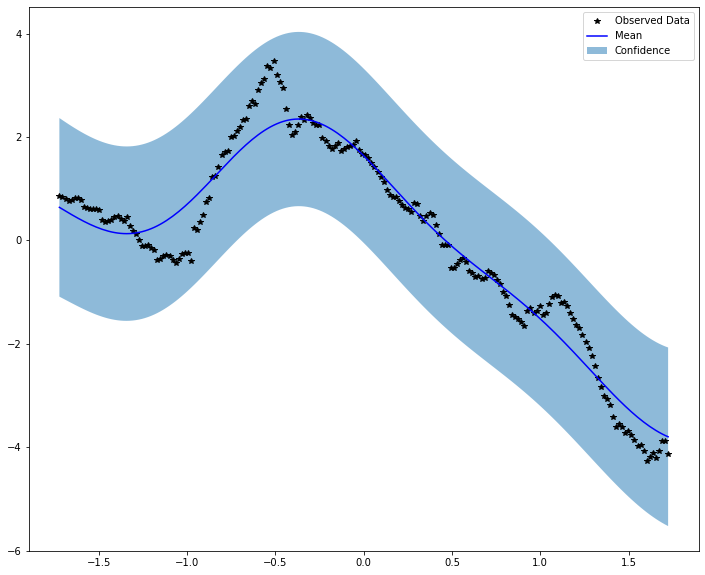

In [38]:
plot_GPFA_latent(m_FA, lh_FA, X)

In [39]:
def train_GPFA(model, likelihood, train_x, train_y, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, model.latent)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)

In [40]:
train_GPFA(m_FA, lh_FA, X, Y)

Iter 1 - Loss: 1.028   lengthscale: 0.644   noise: 0.644 transform: -0.435
Iter 2 - Loss: 0.976   lengthscale: 0.598   noise: 0.598 transform: -0.435
Iter 3 - Loss: 0.927   lengthscale: 0.555   noise: 0.554 transform: -0.435
Iter 4 - Loss: 0.880   lengthscale: 0.515   noise: 0.513 transform: -0.435
Iter 5 - Loss: 0.834   lengthscale: 0.478   noise: 0.474 transform: -0.435
Iter 6 - Loss: 0.786   lengthscale: 0.442   noise: 0.437 transform: -0.435
Iter 7 - Loss: 0.736   lengthscale: 0.409   noise: 0.402 transform: -0.435
Iter 8 - Loss: 0.688   lengthscale: 0.378   noise: 0.369 transform: -0.435
Iter 9 - Loss: 0.642   lengthscale: 0.350   noise: 0.339 transform: -0.435
Iter 10 - Loss: 0.599   lengthscale: 0.326   noise: 0.311 transform: -0.435
Iter 11 - Loss: 0.558   lengthscale: 0.304   noise: 0.284 transform: -0.435
Iter 12 - Loss: 0.518   lengthscale: 0.286   noise: 0.260 transform: -0.435
Iter 13 - Loss: 0.480   lengthscale: 0.272   noise: 0.237 transform: -0.435
Iter 14 - Loss: 0.444

In [41]:
list(m_FA.parameters())

[Parameter containing:
 tensor([-0.4347,  0.1831, -0.4483, -0.2339,  0.5108,  0.5108],
        dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-4.6492], requires_grad=True),
 Parameter containing:
 tensor([-0.0816], requires_grad=True),
 Parameter containing:
 tensor(2.2822, requires_grad=True),
 Parameter containing:
 tensor([[-2.0880]], requires_grad=True)]

In [42]:
m_FA.transform

Parameter containing:
tensor([-0.4347,  0.1831, -0.4483, -0.2339,  0.5108,  0.5108],
       dtype=torch.float64, requires_grad=True)

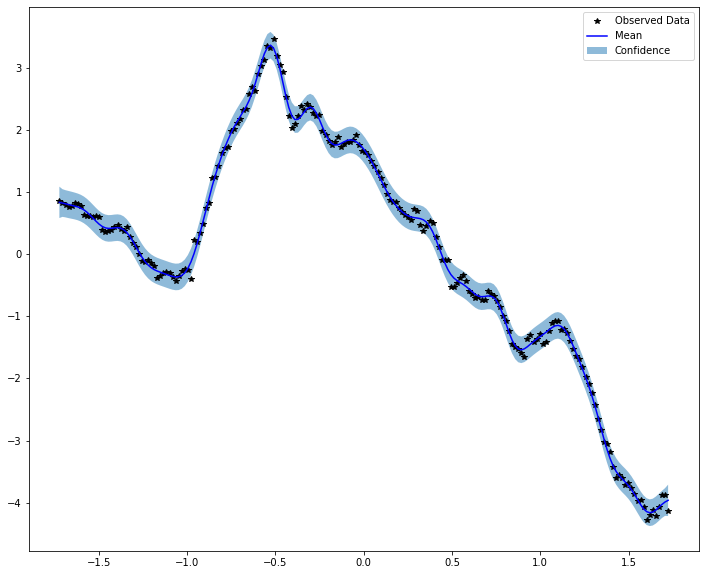

In [43]:
plot_GPFA_latent(m_FA, lh_FA, X)

so far is working, which is already a good step forward. Nice to see that is fitting much better in the lower dimension that for TA, the problem is that is not doing the training for the transformation

## Training factor analysis attempt 2

seems there is a problem with the no_grad in the latent variable calculation...

In [44]:
# We will use the simplest form of GP model, exact inference
class GPFA(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        with torch.no_grad():
            transform = self._init_pca(train_y)
            train_targets = torch.matmul(train_y, transform)
        super(GPFA, self).__init__(train_x, train_targets, likelihood)

        self.train_y = train_y # This is the original data, which is going to be retransformed at every iteration

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transform = torch.nn.Parameter(transform)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    @torch.no_grad()
    def update_training_data(self):
        targets = torch.matmul(self.train_y, self.transform)
        self.set_train_data(targets=targets)

    def __call__(self, *args, **kwargs):
        self.update_training_data()
        return super().__call__(*args, **kwargs)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f transform: %.3f' % (
            i + 1,  loss.item(),
            self.covar_module.base_kernel.lengthscale.item(),
            self.likelihood.noise.item(),
            self.transform[0].item()
        ))

    @property
    def latent(self):
        return torch.matmul(self.train_y, self.transform)

    def _init_pca(self, train_y):
        U, S, V = torch.pca_lowrank(train_y, q = 1)
        return V[:,:1].squeeze()

# need to seed for reproducible PCA in pytorch, see https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html
torch.manual_seed(100)
# initialize likelihood and model
lh_FA = gpytorch.likelihoods.GaussianLikelihood()
m_FA = GPFA(X, Y, lh_FA)

In [45]:
m_FA.eval()
pred_dist = m_FA(X)

In [46]:
pred_dist

MultivariateNormal(loc: torch.Size([200]))

In [47]:
@torch.no_grad()
def plot_GPFA_latent(model, lh, test_x = torch.linspace(0, 1, 51)):
    pred_dist = predict(model, lh, test_x)
    f, ax = plt.subplots(1, 1, figsize=(12, 10))
    # Get upper and lower confidence bounds
    lower, upper = pred_dist.confidence_region()

    latent = model.latent.cpu().numpy()
    train_x = model.train_inputs[0].cpu().numpy()
    # Plot training data as black stars
    ax.plot(train_x, latent, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), pred_dist.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [48]:
m_FA.transform

Parameter containing:
tensor([-0.4347,  0.1831, -0.4483, -0.2339,  0.5108,  0.5108],
       dtype=torch.float64, requires_grad=True)

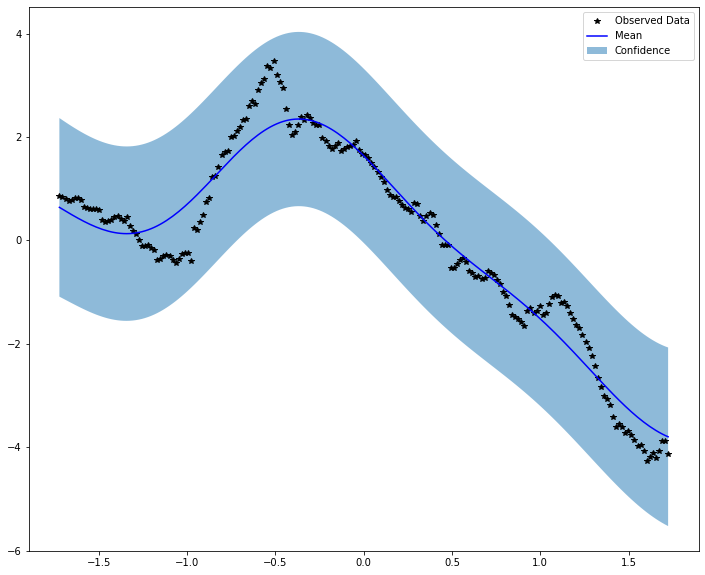

In [49]:
plot_GPFA_latent(m_FA, lh_FA, X)

In [50]:
def train_GPFA(model, likelihood, train_x, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, model.latent)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)

In [51]:
train_GPFA(m_FA, lh_FA, X)

Iter 1 - Loss: 1.028   lengthscale: 0.644   noise: 0.644 transform: -0.335
Iter 2 - Loss: 0.872   lengthscale: 0.602   noise: 0.598 transform: -0.238
Iter 3 - Loss: 0.769   lengthscale: 0.567   noise: 0.554 transform: -0.146
Iter 4 - Loss: 0.706   lengthscale: 0.541   noise: 0.513 transform: -0.062
Iter 5 - Loss: 0.665   lengthscale: 0.521   noise: 0.474 transform: 0.011
Iter 6 - Loss: 0.629   lengthscale: 0.507   noise: 0.437 transform: 0.071
Iter 7 - Loss: 0.593   lengthscale: 0.496   noise: 0.402 transform: 0.116
Iter 8 - Loss: 0.555   lengthscale: 0.487   noise: 0.369 transform: 0.145
Iter 9 - Loss: 0.516   lengthscale: 0.481   noise: 0.339 transform: 0.160
Iter 10 - Loss: 0.477   lengthscale: 0.477   noise: 0.311 transform: 0.162
Iter 11 - Loss: 0.439   lengthscale: 0.474   noise: 0.284 transform: 0.153
Iter 12 - Loss: 0.399   lengthscale: 0.472   noise: 0.260 transform: 0.135
Iter 13 - Loss: 0.358   lengthscale: 0.470   noise: 0.237 transform: 0.112
Iter 14 - Loss: 0.314   length

In [52]:
list(m_FA.parameters())

[Parameter containing:
 tensor([-0.0065,  0.0189, -0.0089,  0.0025, -0.0022, -0.0022],
        dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-5.2409], requires_grad=True),
 Parameter containing:
 tensor([-0.0311], requires_grad=True),
 Parameter containing:
 tensor(-1.6555, requires_grad=True),
 Parameter containing:
 tensor([[1.2034]], requires_grad=True)]

In [53]:
m_FA.transform

Parameter containing:
tensor([-0.0065,  0.0189, -0.0089,  0.0025, -0.0022, -0.0022],
       dtype=torch.float64, requires_grad=True)

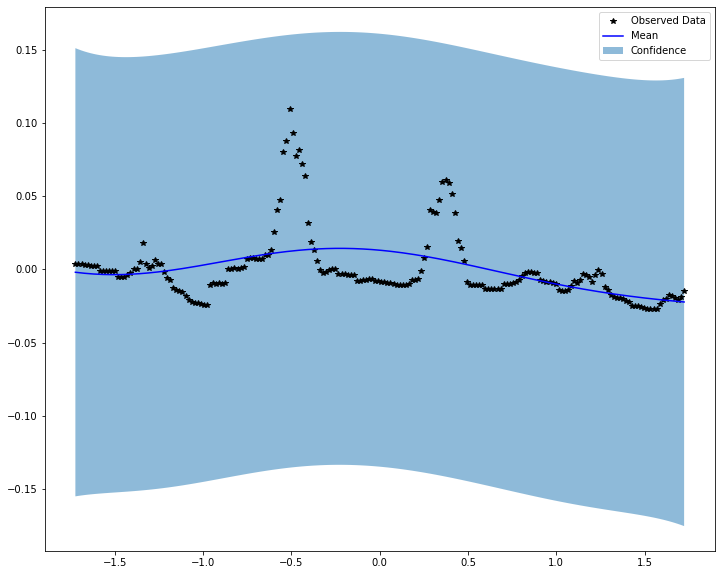

In [54]:
plot_GPFA_latent(m_FA, lh_FA, X)

well now is training the transformation, but seems there is a problem with loss as the results are not great
try to cal the RMSE and see how that changes

## Training factor analysis attempt 3 - Failing properly

this is the right implementation of the idea in attempt 1 and 2, solving the problem with torch grads, but is still not working because the gradient of the transform in relation to the weights is by definition 0

In [55]:
# We will use the simplest form of GP model, exact inference
class GPFA(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        with torch.no_grad():
            transform = self._init_pca(train_y)
            train_targets = torch.matmul(train_y, transform)
        super(GPFA, self).__init__(train_x, train_targets, likelihood)

        self.train_y = train_y # This is the original data, which is going to be retransformed at every iteration

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transform = torch.nn.Parameter(transform)
        self.latent = train_targets

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def update_training_data(self):
        self.latent = torch.matmul(self.train_y, self.transform)
        self.set_train_data(targets=self.latent)

    def __call__(self, *args, **kwargs):
        self.update_training_data()
        return super().__call__(*args, **kwargs)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f transform: %.3f' % (
            i + 1,  loss.item(),
            self.covar_module.base_kernel.lengthscale.item(),
            self.likelihood.noise.item(),
            self.transform[0].item()
        ))


    def _init_pca(self, train_y):
        U, S, V = torch.pca_lowrank(train_y, q = 1)
        return V[:,:1].squeeze()

# need to seed for reproducible PCA in pytorch, see https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html
torch.manual_seed(100)
# initialize likelihood and model
lh_FA = gpytorch.likelihoods.GaussianLikelihood()
m_FA = GPFA(X, Y, lh_FA)

In [56]:
m_FA.eval()
pred_dist = m_FA(X)

In [57]:
pred_dist

MultivariateNormal(loc: torch.Size([200]))

In [58]:
m_FA.transform

Parameter containing:
tensor([-0.4347,  0.1831, -0.4483, -0.2339,  0.5108,  0.5108],
       dtype=torch.float64, requires_grad=True)

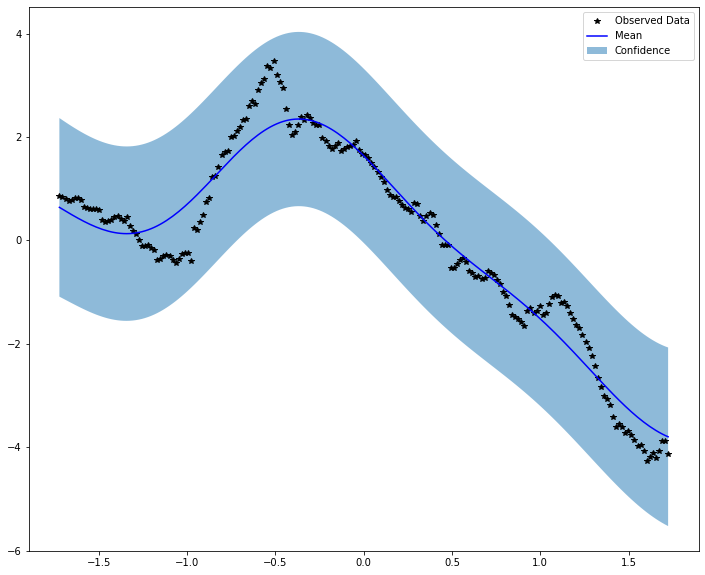

In [59]:
plot_GPFA_latent(m_FA, lh_FA, X)

In [60]:
train_GPFA(m_FA, lh_FA, X)

Iter 1 - Loss: 1.028   lengthscale: 0.644   noise: 0.644 transform: -0.335
Iter 2 - Loss: 0.872   lengthscale: 0.602   noise: 0.598 transform: -0.238
Iter 3 - Loss: 0.769   lengthscale: 0.567   noise: 0.554 transform: -0.146
Iter 4 - Loss: 0.706   lengthscale: 0.541   noise: 0.513 transform: -0.062
Iter 5 - Loss: 0.665   lengthscale: 0.521   noise: 0.474 transform: 0.011
Iter 6 - Loss: 0.629   lengthscale: 0.507   noise: 0.437 transform: 0.071
Iter 7 - Loss: 0.593   lengthscale: 0.496   noise: 0.402 transform: 0.116
Iter 8 - Loss: 0.555   lengthscale: 0.487   noise: 0.369 transform: 0.145
Iter 9 - Loss: 0.516   lengthscale: 0.481   noise: 0.339 transform: 0.160
Iter 10 - Loss: 0.477   lengthscale: 0.477   noise: 0.311 transform: 0.162
Iter 11 - Loss: 0.439   lengthscale: 0.474   noise: 0.284 transform: 0.153
Iter 12 - Loss: 0.399   lengthscale: 0.472   noise: 0.260 transform: 0.135
Iter 13 - Loss: 0.358   lengthscale: 0.470   noise: 0.237 transform: 0.112
Iter 14 - Loss: 0.314   length

In [61]:
list(m_FA.parameters())

[Parameter containing:
 tensor([-0.0065,  0.0189, -0.0089,  0.0025, -0.0022, -0.0022],
        dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-5.2409], requires_grad=True),
 Parameter containing:
 tensor([-0.0311], requires_grad=True),
 Parameter containing:
 tensor(-1.6555, requires_grad=True),
 Parameter containing:
 tensor([[1.2034]], requires_grad=True)]

In [62]:
m_FA.transform

Parameter containing:
tensor([-0.0065,  0.0189, -0.0089,  0.0025, -0.0022, -0.0022],
       dtype=torch.float64, requires_grad=True)

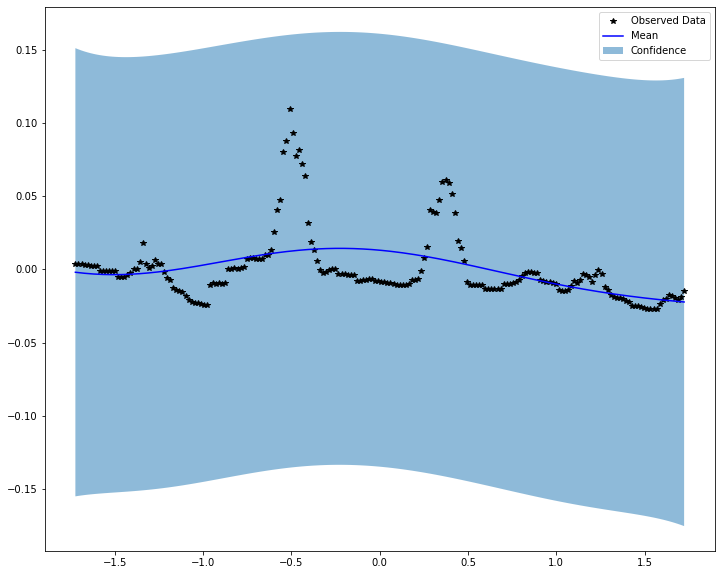

In [63]:
plot_GPFA_latent(m_FA, lh_FA, X)

well now is training the transformation, but seems there is a problem with loss as the results are not great
try to cal the RMSE and see how that changes

of course there a problem with the loss .... is calculated between the latent before and after the transformation, which makes no sense ...

I am not modelling noise in the GPFA

In [71]:
def train_GPFA_rmse(model, likelihood, train_x, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        latent = model.latent
        # Calc loss and backprop gradients
        loss = -mll(output, latent)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)
        rmse = torch.sqrt(torch.mean((output.mean - model.latent) **2)).item()
        print("rmse: %.3f mean_transform: %.3f" % (rmse, model.transform.detach().mean().item()))

In [76]:
out = lh_FA(m_FA(X))

In [83]:
m_FA.latent.dtype

torch.float64

In [65]:
lh_FA = gpytorch.likelihoods.GaussianLikelihood()
m_FA = GPFA(X, Y, lh_FA)

In [72]:
train_GPFA_rmse(m_FA, lh_FA, X)

KeyboardInterrupt: 

In [67]:
train_GPFA_rmse(m_FA, lh_FA, X, 100)

Iter 1 - Loss: -1.580   lengthscale: 1.530   noise: 0.005 transform: 0.092
rmse: 0.074 mean_transform: -0.031
Iter 2 - Loss: 1.288   lengthscale: 1.474   noise: 0.005 transform: 0.024
rmse: 0.356 mean_transform: -0.008
Iter 3 - Loss: -1.465   lengthscale: 1.430   noise: 0.005 transform: -0.041
rmse: 0.114 mean_transform: 0.014
Iter 4 - Loss: -1.041   lengthscale: 1.390   noise: 0.006 transform: -0.071
rmse: 0.186 mean_transform: 0.023
Iter 5 - Loss: -0.085   lengthscale: 1.343   noise: 0.006 transform: -0.067
rmse: 0.288 mean_transform: 0.021
Iter 6 - Loss: -0.452   lengthscale: 1.294   noise: 0.006 transform: -0.042
rmse: 0.260 mean_transform: 0.012
Iter 7 - Loss: -1.212   lengthscale: 1.249   noise: 0.006 transform: -0.008
rmse: 0.160 mean_transform: 0.002
Iter 8 - Loss: -1.518   lengthscale: 1.211   noise: 0.007 transform: 0.027
rmse: 0.044 mean_transform: -0.007
Iter 9 - Loss: -1.297   lengthscale: 1.177   noise: 0.007 transform: 0.055
rmse: 0.096 mean_transform: -0.011
Iter 10 - L

In [68]:
m_FA.transform

Parameter containing:
tensor([ 0.0039,  0.0030, -0.0012,  0.0020,  0.0011,  0.0011],
       dtype=torch.float64, requires_grad=True)

so seems what is doing is making the latent very small, so then the error of the latent is very small

## Attempt 4 -

This is another simple attempt (hoping to learn something on the way ...) of calculating the loss on the original Y not on the latent, as a loss I am using RMSE (as log likehood is not going to work with the transformation)

In [55]:
# We will use the simplest form of GP model, exact inference
class GPFA4(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        with torch.no_grad():
            transform = self._init_pca(train_y)
            train_targets = torch.matmul(train_y, transform)
        super(GPFA4, self).__init__(train_x, train_targets, likelihood)

        self.train_y = train_y # This is the original data, which is going to be retransformed at every iteration

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transform = torch.nn.Parameter(transform)
        self.latent = train_targets

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def update_training_data(self):
        self.latent = torch.matmul(self.train_y, self.transform)
        self.set_train_data(targets=self.latent)

    def __call__(self, *args, **kwargs):
        self.update_training_data()
        return super().__call__(*args, **kwargs)

    def printer(self, i, loss):
        print('Iter %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f transform: %.3f' % (
            i + 1,  loss.item(),
            self.covar_module.base_kernel.lengthscale.item(),
            self.likelihood.noise.item(),
            self.transform[0].item()
        ))


    def _init_pca(self, train_y):
        U, S, V = torch.pca_lowrank(train_y, q = 1)
        return V[:,:1].squeeze()

# need to seed for reproducible PCA in pytorch, see https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html
torch.manual_seed(100)
# initialize likelihood and model
lh4 = gpytorch.likelihoods.GaussianLikelihood()
m4 = GPFA4(X, Y, lh4)

In [90]:
torch.inverse(m_FA.transform.detach().unsqueeze(1))

RuntimeError: linalg.inv_ex: A must be batches of square matrices, but they are 1 by 6 matrices

This is the transformation to obtain $Z$

$$Z = YT$$

now we need to get $Y$ given $Z$ .... seems this is actually not possible https://math.stackexchange.com/a/86241

Actually this reminds that we do need to add the random noise here otherwise the whole idea doesn't work

In [71]:
def train_GPFA4(model, likelihood, train_x, train_y, training_iter=50):
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        pred_latent = likelihood(model(train_x)).mean()

        pred_y = torch.matmul(pred_latent, torch.inverse()



        # Calc loss and backprop gradients
        loss = -mll(output, latent)
        loss.backward()
        optimizer.step()
        model.printer(i, loss)
        rmse = torch.sqrt(torch.mean((output.mean - model.latent) **2)).item()
        print("rmse: %.3f mean_transform: %.3f" % (rmse, model.transform.detach().mean().item()))